In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import shap
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [72]:
db = pd.read_excel("Retail-Supply-Chain-Sales-Dataset.xlsx")

In [73]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Row ID               9994 non-null   int64         
 1   Order ID             9994 non-null   object        
 2   Order Date           9994 non-null   datetime64[ns]
 3   Ship Date            9994 non-null   datetime64[ns]
 4   Ship Mode            9994 non-null   object        
 5   Customer ID          9994 non-null   object        
 6   Customer Name        9994 non-null   object        
 7   Segment              9994 non-null   object        
 8   Country              9994 non-null   object        
 9   City                 9994 non-null   object        
 10  State                9994 non-null   object        
 11  Postal Code          9994 non-null   int64         
 12  Region               9994 non-null   object        
 13  Retail Sales People  9994 non-nul

In [74]:
target = db.iloc[:,[4,6,7,9,11,12] + list(range(16,22))].copy()

In [75]:
target['Duration'] =db['Ship Date']-db['Order Date']
target['Ship Day'] = db['Ship Date'].dt.dayofweek
target['Ship Month']= db['Ship Date'].dt.month
target['Order Month'] = db['Order Date'].dt.month
target.sample(5)

,Ship Mode,Customer Name,Segment,City,Postal Code,Region,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month
6936,First Class,Tom Ashbrook,Home Office,Chicago,60653,Central,Furnishings,Deflect-o DuraMat Antistatic Studded Beveled M...,Not,84.272,2,0.6,60 days,5,4,2
1208,Second Class,Steven Ward,Corporate,New York City,10009,East,Fasteners,Ideal Clamps,Not,14.070,7,0.0,4 days,0,7,7
9169,Standard Class,Sanjit Jacobs,Home Office,Jackson,39212,South,Paper,Xerox 1964,Not,45.680,2,0.0,4 days,5,3,3
8723,Second Class,Marc Harrigan,Home Office,Miami,33178,South,Paper,Xerox 1898,Not,37.408,7,0.2,2 days,5,12,12
9045,Second Class,Kalyca Meade,Corporate,Sunnyvale,94086,West,Accessories,Imation Secure Drive + Hardware Encrypted USB ...,Not,189.950,5,0.0,4 days,2,12,12


In [76]:
target['Returned']=db['Returned'].map({'Yes':1,'Not':0})
def extract_brand(product_name):
    if isinstance(product_name,str):
        return product_name.split()[0].strip(",").title()
    return "Unknown"
target['Brand']=target['Product Name'].apply(extract_brand)
target['Duration']=target['Duration'].dt.days
target.sample(5)

,Ship Mode,Customer Name,Segment,City,Postal Code,Region,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month,Brand
8896,Standard Class,Bill Donatelli,Consumer,Los Angeles,90004,West,Phones,AT&T 841000 Phone,0,165.600,3,0.2,7,0,8,8,At&T
6886,Standard Class,Helen Abelman,Consumer,Springfield,45503,East,Phones,Cisco IP Phone 7961G-GE VoIP phone,0,259.896,2,0.4,0,0,10,10,Cisco
7666,Standard Class,Daniel Raglin,Home Office,Providence,2908,East,Copiers,Hewlett Packard LaserJet 3310 Copier,0,5399.910,9,0.0,122,2,8,4,Hewlett
1050,First Class,Deirdre Greer,Corporate,Philadelphia,19134,East,Furnishings,Eldon Antistatic Chair Mats for Low to Medium ...,0,168.464,2,0.2,61,3,5,3,Eldon
5389,Second Class,Cynthia Voltz,Corporate,Los Angeles,90045,West,Labels,Avery 493,0,9.820,2,0.0,3,1,2,2,Avery


In [82]:
encoding_cols = ['Ship Mode','Segment','Sub-Category','Brand','City','Region']
for cols in encoding_cols:
    for cols in encoding_cols:
        le = LabelEncoder()
        target[cols] = le.fit_transform(target[cols])
target.drop(columns=['Product Name','Customer Name','Sales'],inplace= True)
target.sample(4)

,Ship Mode,Segment,City,Postal Code,Region,Sub-Category,Returned,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month,Brand
6747,3,0,329,10035,1,3,0,1,0.2,33,4,12,11,102
1976,2,1,310,36116,2,13,0,5,0.0,2,0,10,10,55
7996,0,2,437,92037,3,0,0,5,0.0,61,3,5,3,278
3556,3,0,266,90008,3,12,1,7,0.0,120,4,5,1,461


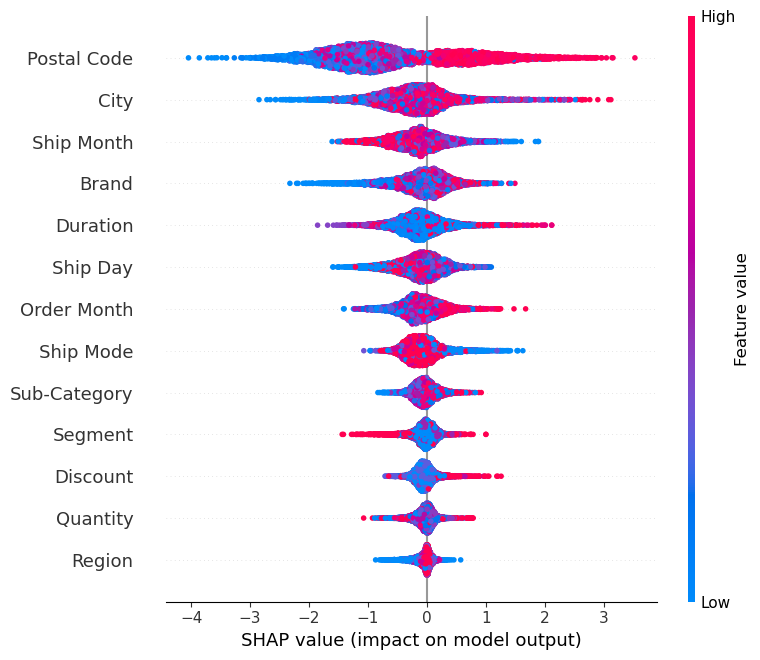

In [84]:
x1 = target.drop(columns=['Returned'])
y = target['Returned']
x_train,x_test,y_train,y_test = train_test_split(x1,y,test_size=0.2,random_state=42,stratify=y)
XGB_test=XGBClassifier(eval_metric='logloss', random_state=42)
XGB_test.fit(x_train,y_train)
explainer = shap.TreeExplainer(XGB_test)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values,x_train)

In [94]:
X = target.drop(columns=['Returned','Sub-Category','Discount'])
y = target['Returned']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42, stratify=y)
XGB = XGBClassifier( eval_metric = 'logloss', random_state = 42)
XGB.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [96]:
y_pred = XGB.predict(x_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))

Accuracy:  0.9439719859929965
